# Final Exam
## Arash Modaresi Rad
### Collaborate: Amir Kazemzadeh & Ahmad Hojatimalekshah (Problem 6)
#### Deadline: MAY 7, 2020

In [1]:
import numpy as np
from numpy.random import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

 <br/>
 <br/>

 ## Expectation Maximization (EM) Algorithm

 ---
 ---

 ### Problem 1: Implement the Expectation Maximization (EM) algorithm for the  Gaussian Mixture Model in python. (20 points)



 > __NOTE__: NAN.

 ---


In [2]:
from scipy.stats import norm, multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits import mplot3d
from matplotlib import cm

The Expectation Maximization (EM) algorithm consists of two steps, an E-step or Expectation step and M-step or Maximisation step. Let’s say we have some latent variables 𝛾 (which are unobserved and denoted by the vector Z below) and our data points X. Our goal is to maximise the marginal likelihood of X given our parameters (denoted by the vector θ)

To estimate our Gaussian Mixture model essentially we only need to carry out two steps. In the first step (E-step) we want to estimate the posterior distribution of our latent variables 𝛾 conditional on our weights (π) means (µ)and covariance (Σ) of our Gaussians. The vector of parameters is denoted as θ in Figure 1. Estimating the E-step requires initialising these values first and we can do this with k-means which is usually a good starting point (more on this in the code below). We can then move to the second step (M-step) and use 𝛾 to maximise the likelihood with respect to our parameters θ. This process is repeated until the algorithm converges (loss function doesn't change). We can write the Gaussian Mixture distribution as a combination of Gaussians with weights equal to π as below. Where K is the number of Gaussians we want to model.

**E-Step**

\begin{equation*}
p(x) = \sum_{i=1}^I \pi_{i} N(x|\mu_i,\sum_i)
\end{equation*}

we can calculate the posterior distribution of the responsibilities that each Gaussian has for each data point using the Bayes rule where π is the prior weights and the likelihood is normal.

\begin{equation*}
\gamma(Z_{n,i}) = \frac{\pi_{i} N(x_n|\mu_i,\sum_i)}{\sum_{j=1}^I \pi_{j} N(x_n|\mu_j,\sum_j)}
\end{equation*}

**M-Step**

Now we estimate the parameters of each Gaussian defined by the equations below and then evaluate the log-likelihood. These two steps are then repeated until convergence. So Mean of the Gaussians can be expressed as:

\begin{equation*}
\mu_{i}^{update} = \frac{1}{N_i}\sum_{n=1}^{N} \gamma(Z_{ni})x_n
\end{equation*} 

with covariance matrix of Gaussians:

\begin{equation*}
\sum_{i}^{update} = \frac{1}{N_i}\sum_{n=1}^{N} \gamma(Z_{ni})(x_n-\mu_{i}^{update})(x_n-\mu_{i}^{update})^T
\end{equation*} 

and weights being:

\begin{equation*}
\pi_{i}^{update} = \frac{N_i}{N}
\end{equation*}

where

\begin{equation*}
N_i = \sum_{n=1}^{N} \gamma(Z_{ni})
\end{equation*}

with the objective being the maximization of the marginal likelihood:

\begin{equation*}
\ln p (X|\mu,\sum, \pi) = \sum_{n=1}^{N} \ln\left(\sum_{i=1}^{I} \pi_i N(x_n|\mu_i,\sum_i) \right)
\end{equation*}

**Implementing the EM algorithm for the Gaussian Mixture Model**

Generate the data:

In [3]:
def generate_data(n_data, means, covariances, weights):
    """creates a list of data points"""
    n_clusters, n_features = means.shape
    
    data = np.zeros((n_data, n_features))
    for i in range(n_data):
        k = np.random.choice(n_clusters, size = 1, p = weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data[i] = x
   
    return data
init_means = np.array([
    [5, 0],
    [1, 1]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
])

init_weights = [1 / 4, 3 / 4]
n_data = 1000
N_Data = generate_data(n_data, init_means, init_covariances, init_weights)

Ploting

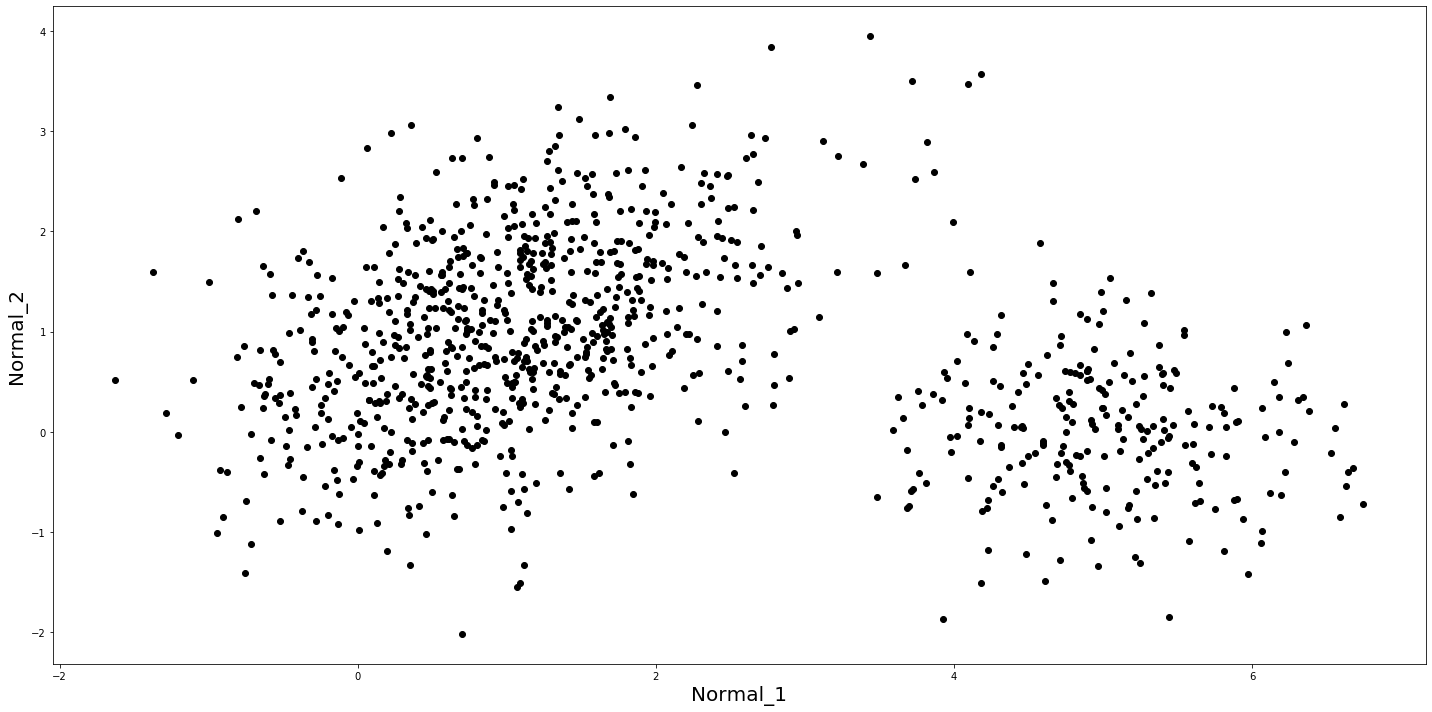

In [4]:
fig = plt.figure(figsize = (20,10))
X = N_Data
plt.plot(N_Data[:, 0], N_Data[:, 1], 'ko')
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
plt.tight_layout()

In [5]:
class GMM_Function:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed
        self.log_likelihood = 0

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            self.log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(self.log_likelihood)
            #print('likelihood is:',self.log_likelihood_trace)

        #print('likelihood is:',self.log_likelihood_trace)
        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self

**Compute the maximum likelihood values:**

In [6]:
X = N_Data
gmm = GMM_Function(n_components = 2, n_iters = 30, tol = 1e-4, seed = 4)
MLE_Means = gmm.fit(X).means
MLE_Covariances = gmm.covs
MLE_PI = gmm.weights
print('The MLE PI parameter for first and seccond distribution respectively is : \n' + str(MLE_PI) + '\n')
print('The MLE mean parameter for first and seccond distribution respectively is: \n' + str(MLE_Means)+ '\n')
print('The MLE covariance parameter for first and seccond distribution respectively is: \n' + str(MLE_Covariances)+ '\n')

The MLE PI parameter for first and seccond distribution respectively is : 
[0.24165063 0.75834937]

The MLE mean parameter for first and seccond distribution respectively is: 
[[4.98882716 0.01772953]
 [1.00052323 1.0388114 ]]

The MLE covariance parameter for first and seccond distribution respectively is: 
[[[ 0.53813879 -0.04151131]
  [-0.04151131  0.44609504]]

 [[ 0.87224838  0.38961872]
  [ 0.38961872  0.89899161]]]



**Plot the value of the log-likelihood function vs iteration number. Comment on the
pattern of the plot.**

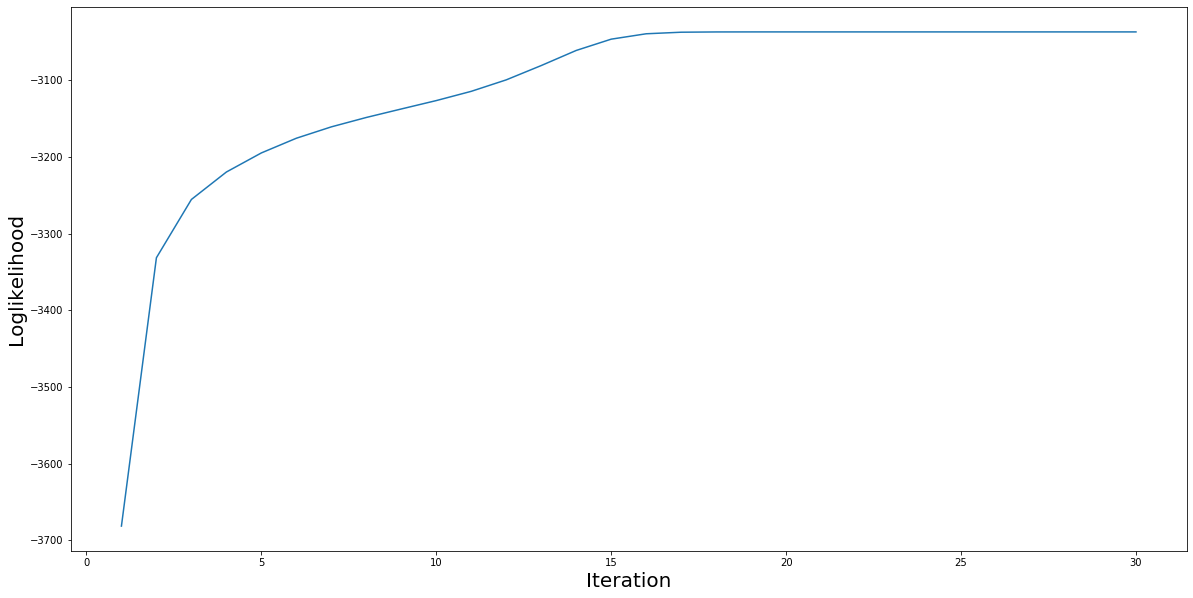

In [7]:
Liklihood = gmm.fit(X).log_likelihood_trace
X_val = np.arange(1,31,1)
plt.figure(figsize=(20,10))
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Loglikelihood',fontsize=20)
plt.plot(X_val,Liklihood)

**Classify each observation into one of the two classes. Display the classification results in
a scatter plot with two different colors.**

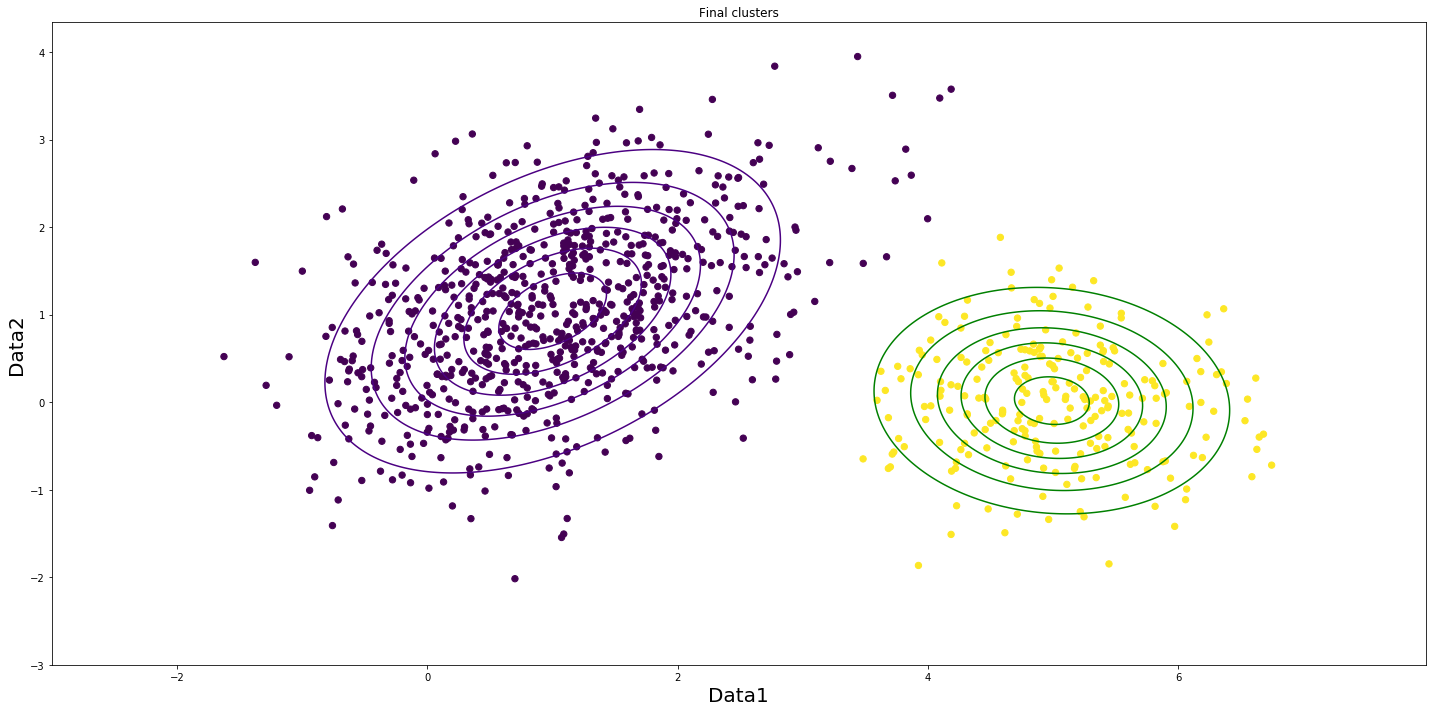

In [8]:
def plot_contours(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure(figsize=(20,10))
    #plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-3.0, 8.0, delta)
    y = np.arange(-3.0, 4.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    gmm = GaussianMixture(n_components=2).fit(data)
    labels = gmm.predict(X)
    

    col = ['green', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]        
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
        
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
    plt.xlabel('Data1',fontsize=20)
    plt.ylabel('Data2',fontsize=20)
    plt.title(title)
    plt.tight_layout()
    
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')

**Plot a surface plot of the fitted PDF f(x; θ^) .**

In [9]:
def plot_surface(data, means, covs, title):
    """visualize the gaussian components over the data"""
    plt.figure(figsize=(20,15))

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-3.0, 9.0, delta)
    y = np.arange(-5.0, 4.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T
    #fig = plt.figure()
    ax = plt.axes(projection='3d')
    mean1 = means[0]
    cov1 = covs[0]
    mean2 = means[1]
    cov2 = covs[1]

    z_grid = multivariate_normal(mean1, cov1).pdf(coordinates).reshape(x_grid.shape) + multivariate_normal(mean2, cov2).pdf(coordinates).reshape(x_grid.shape)
    ax.plot_surface(x_grid, y_grid, z_grid, rstride=20, cstride=20, cmap=cm.bone, edgecolors='r')
    plt.xlabel('Data1',fontsize=20)
    plt.ylabel('Data2',fontsize=20)
    ax.set_zlabel('PDF value',fontsize=20)
    plt.title(title)
    plt.tight_layout()

converged iteration: 50


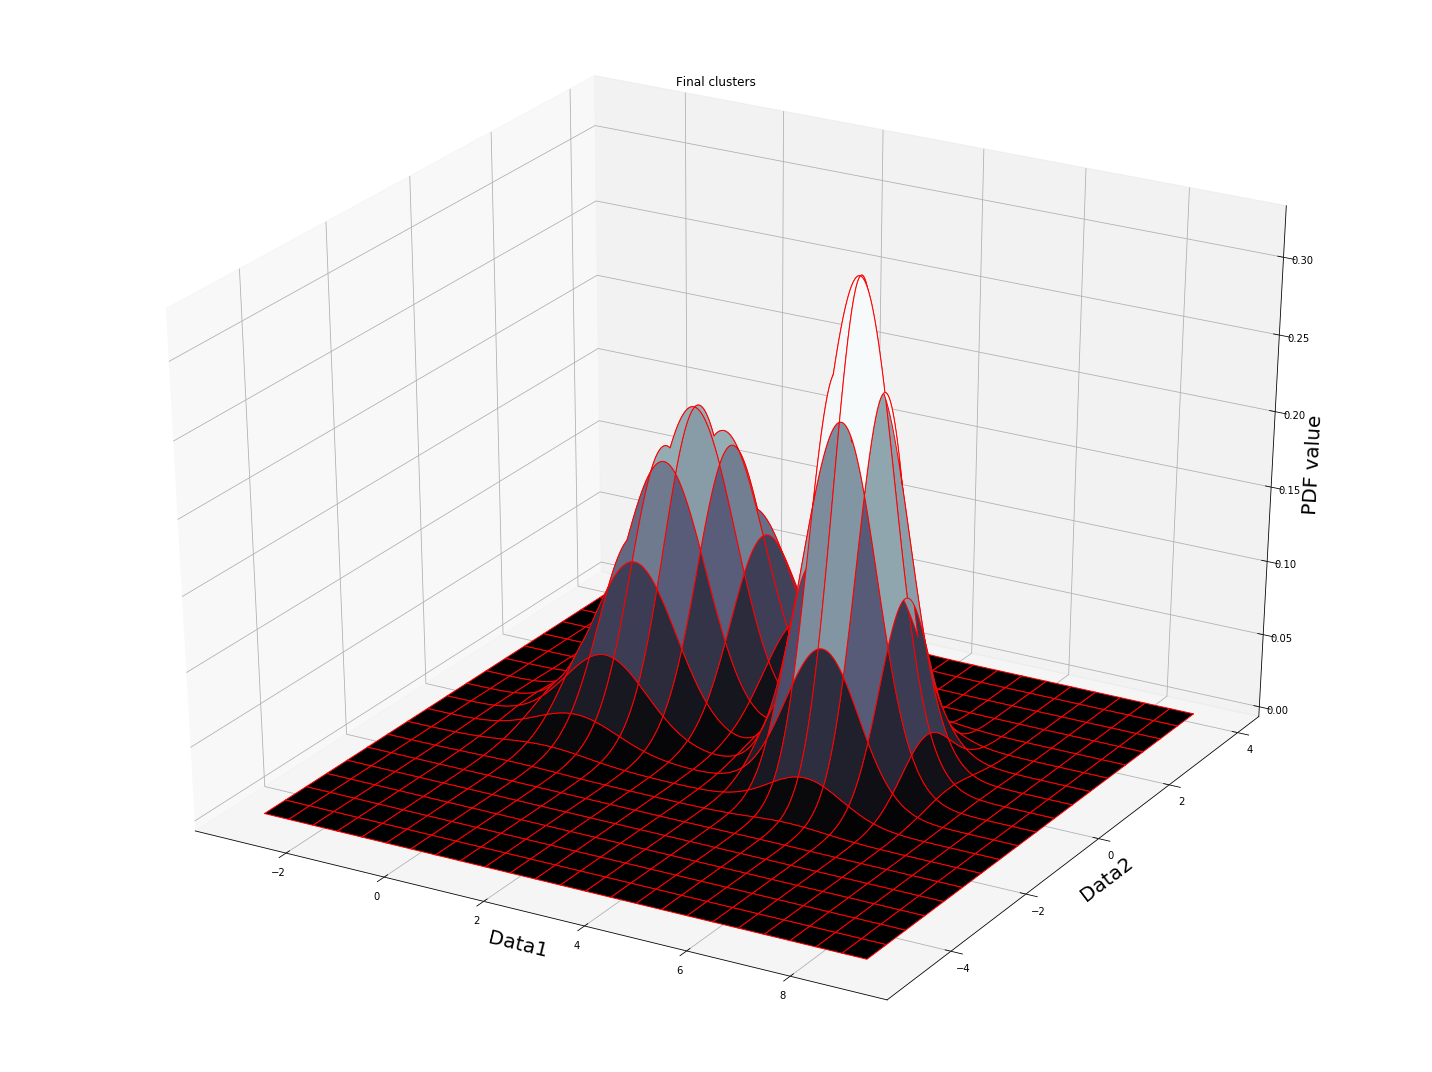

In [10]:
gmm = GMM_Function(n_components = 2, n_iters = 50, tol = 1e-4, seed = 4)
gmm.fit(X)

print('converged iteration:', len(gmm.log_likelihood_trace))
plot_surface(X, gmm.means, gmm.covs, 'Final clusters')

 ### Problem 2: Use with a dataset different from IRIS the following technique.  (20)

>  __NOTE__: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html  (scikit).

 ---


In [11]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing

**Wine Data**

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

In [12]:
from sklearn.datasets import load_wine
data = load_wine()
data1 = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target'])
data1.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


`Standardize`

(array([59.,  0.,  0.,  0.,  0., 71.,  0.,  0.,  0., 48.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

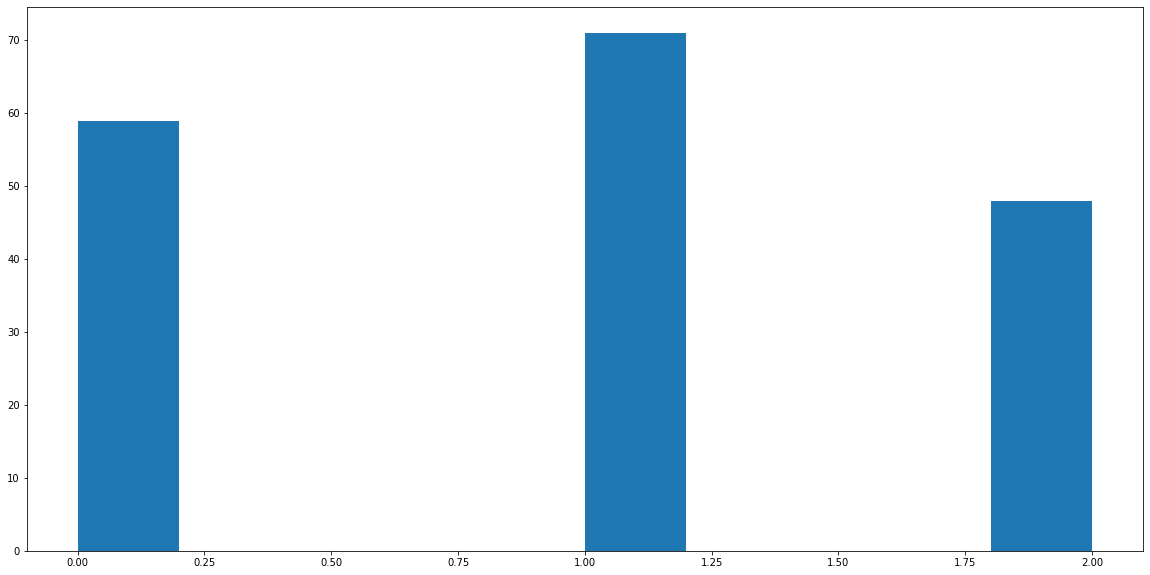

In [13]:
data = data1.iloc[:,:-1]
min_max_scaler = preprocessing.MinMaxScaler()
data = np.array(min_max_scaler.fit_transform(data))
target = np.array(data1['target'])
plt.figure(figsize=(20,10))
plt.hist(target)

`lets assume that our wine targets are only two classes 0 (combined 0 & 2) and 1.`

In [14]:
target[target == 2] = 0

(array([107.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

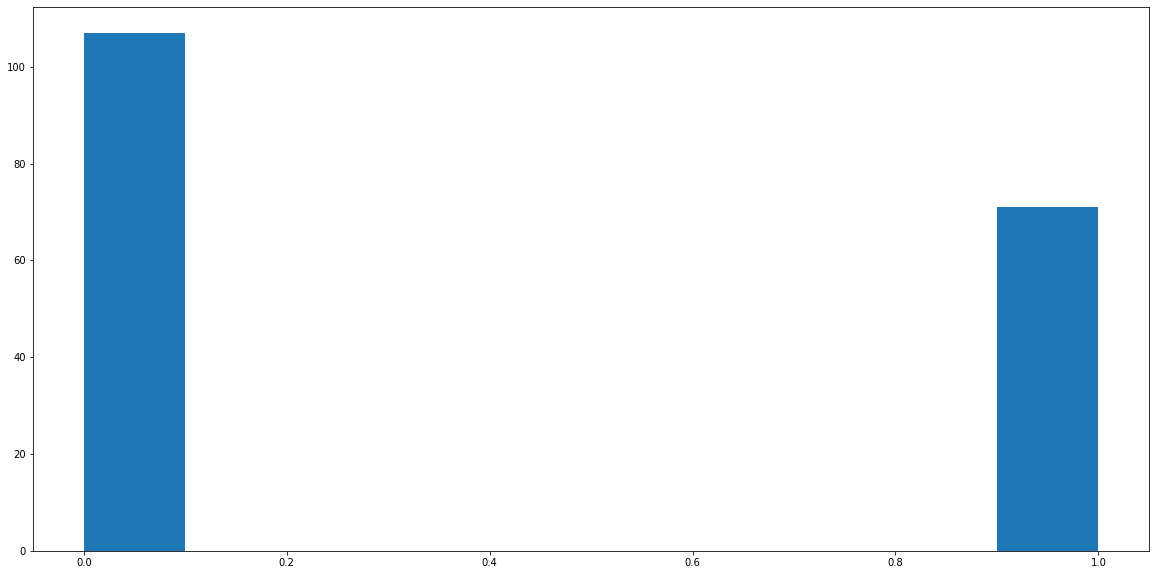

In [15]:
plt.figure(figsize=(20,10))
plt.hist(target)

Feature ranking:
1. feature 9 (0.187472)
2. feature 0 (0.178025)
3. feature 12 (0.164668)
4. feature 6 (0.084480)
5. feature 10 (0.058673)
6. feature 11 (0.057716)
7. feature 4 (0.057477)
8. feature 1 (0.054981)
9. feature 2 (0.048068)
10. feature 3 (0.031673)
11. feature 5 (0.030739)
12. feature 8 (0.027350)
13. feature 7 (0.018676)


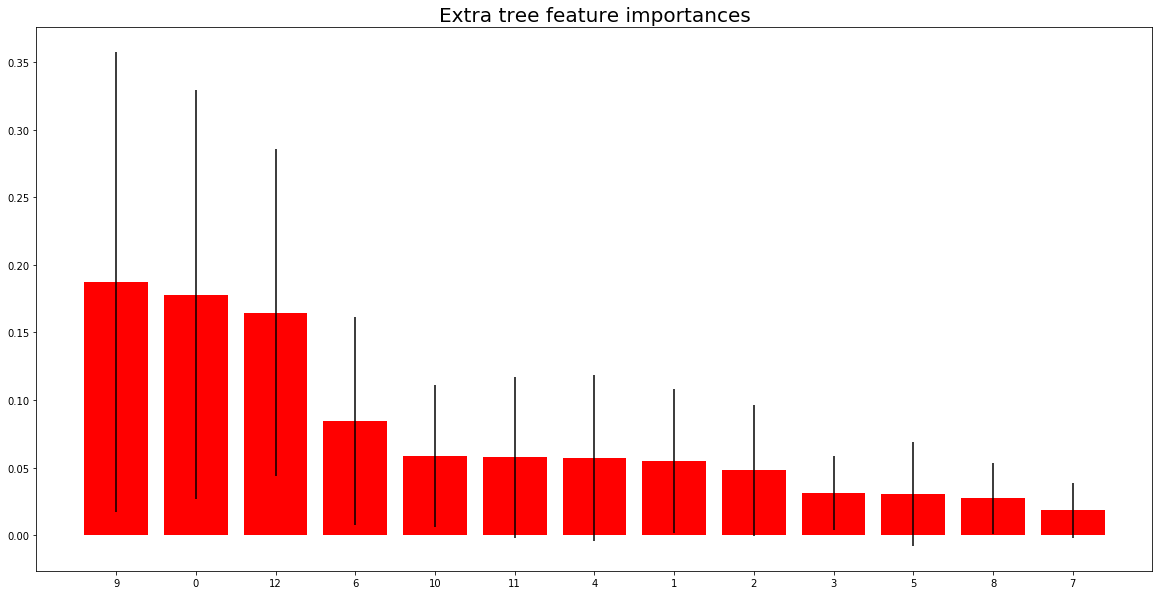

In [16]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

forest.fit(data, target)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Extra tree feature importances",fontsize=20)
plt.bar(range(data.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

The plot suggests that 4 features out of 13 are informative, while the remaining are not.

 ### Problem 3: Compare by discussing results the technique in 2 with the coefficients (W) of the logistic regression. (20)

 

 > __NOTE__: (scikit)

 ---


In [17]:
from sklearn.linear_model import LogisticRegression

Simillarly, we can fit a LogisticRegression model on our dataset and retrieve the coeff_ property that contains the coefficients found for each input variable.These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.

lets label the species numerically

Feature ranking:
1. feature 0 (-3.229956)
2. feature 12 (-3.063830)
3. feature 9 (-2.921526)
4. feature 2 (-1.514309)
5. feature 10 (1.496983)
6. feature 1 (-1.382062)
7. feature 3 (0.901182)
8. feature 11 (0.743298)
9. feature 4 (-0.739604)
10. feature 8 (0.505559)
11. feature 6 (0.400476)
12. feature 7 (0.219398)
13. feature 5 (-0.079460)


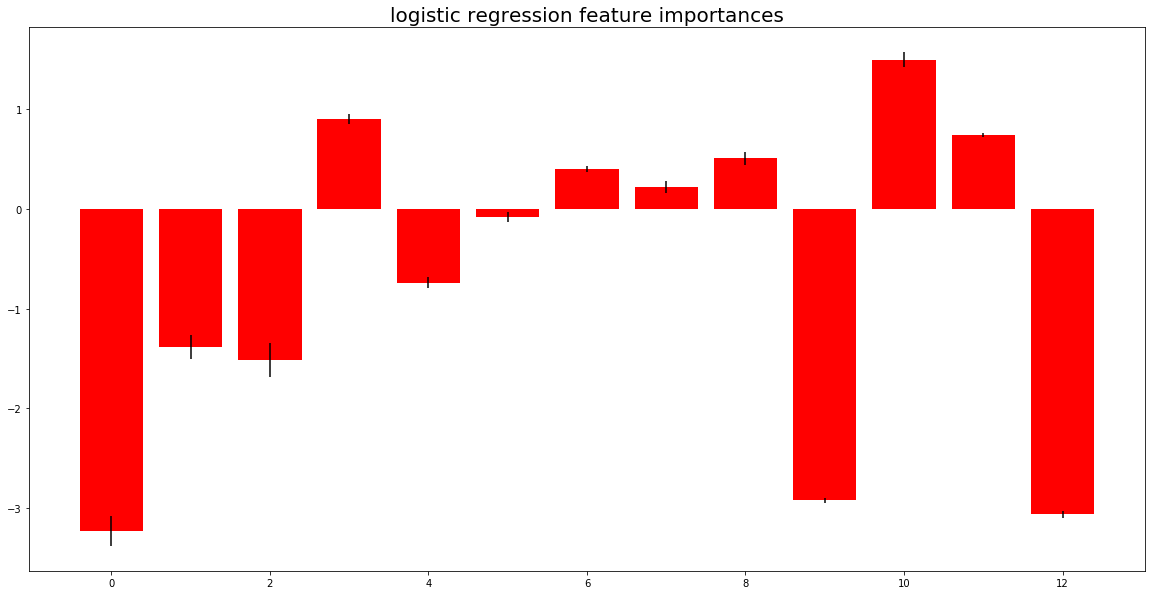

In [18]:
# define the model
model = LogisticRegression()
# fit the model
model.fit(data, target)
# get importance
importance = model.coef_[0]
# summarize feature importance
indices = np.argsort(np.abs(importance))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(20,10))
plt.title("logistic regression feature importances",fontsize=20)
plt.bar([x for x in range(len(importance))], importance,color="r", yerr=std[indices], align="center")
plt.show()

Recall this is a classification problem with classes 0 and 1. Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.

The result of logistic regression is some what simillar to extra tree algorithem as both suggest that features 12, 0, and 9  are the most important one. However, the extra tree algorithem also suggest that 6 is important while logestic suggest that this feature is unimportant.

In general, both Logistic regression and forest can be used forextracting mosy important features that are linearly correlated with target. However, for non linear correlations the forst method is prefered.

 <br/>
 <br/>

 ## Imbalanced Data

 ---
 ---

 ### Problem 4: the IRIS dataset and the binary classification (iris-setosa versus others). This dataset is imbalanced please implement a technique by using to oversampling that will produce a balanced dataset (no duplication). Think of ways of how data can be generated. Extra credit may be assigned if you train models for the generation part (20)


 > __NOTE__: (you can use scikit)

 ---


In [19]:
import random
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Oversampling increases the weight of the minority class by replicating the minority class examples. Although it does not increase information, it raises the over-fitting issue, which causes the model to be too specific. It may well be the case that the accuracy for the training set is high, yet the performance for new datasets is actually worse.

**Different techniques:** <br>
<br>
**Random oversampling** <br>
Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is one of the earliest proposed methods, that is also proven to be robust. [3] Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement. <br>
<br>
**SMOTE** <br>
The most common technique is known as SMOTE: Synthetic Minority Over-sampling Technique. To illustrate how this technique works consider some training data which has s samples, and f features in the feature space of the data. Note that these features, for simplicity, are continuous. As an example, consider a dataset of birds for classification. The feature space for the minority class for which we want to oversample could be beak length, wingspan, and weight (all continuous). To then oversample, take a sample from the dataset, and consider its k nearest neighbors (in feature space). To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point. <br>
<br>
**ADASYN** <br>
The adaptive synthetic sampling approach, or ADASYN algorithm, builds on the methodology of SMOTE, by shifting the importance of the classification boundary to those minority classes which are difficult. ADASYN uses a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn. <br>

convert to a bainery target

(array([ 50.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

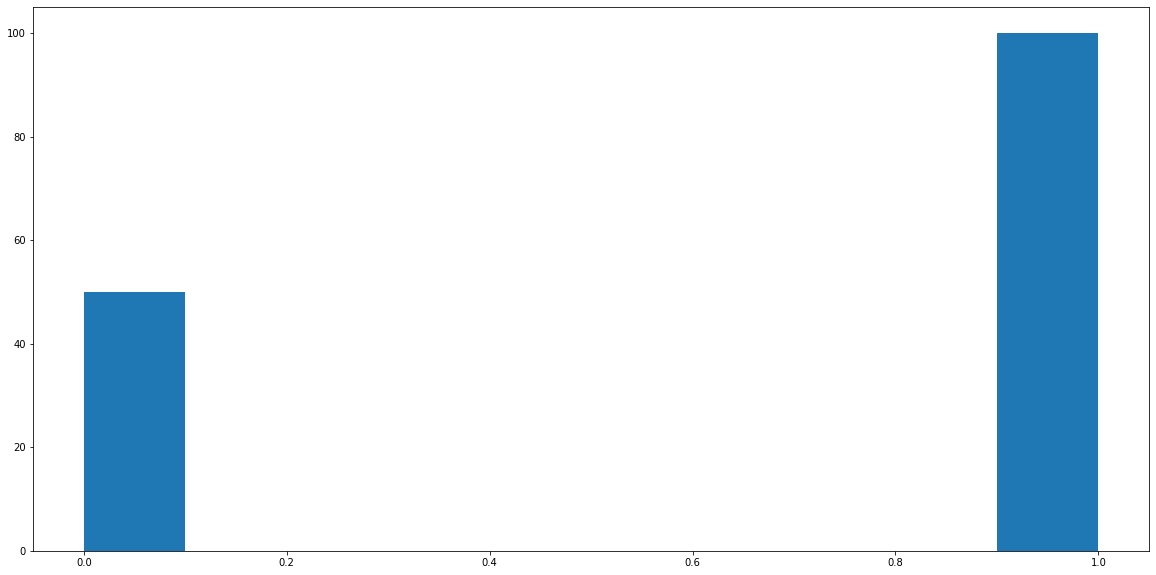

In [20]:
iris = load_iris()
data = iris.data
target = iris.target 
target[target != 0]=1    # Iris-Setosa vs. others
plt.figure(figsize=(20,10))
plt.hist(target)

In [21]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state=1000)

Lets look at the distribution of data:

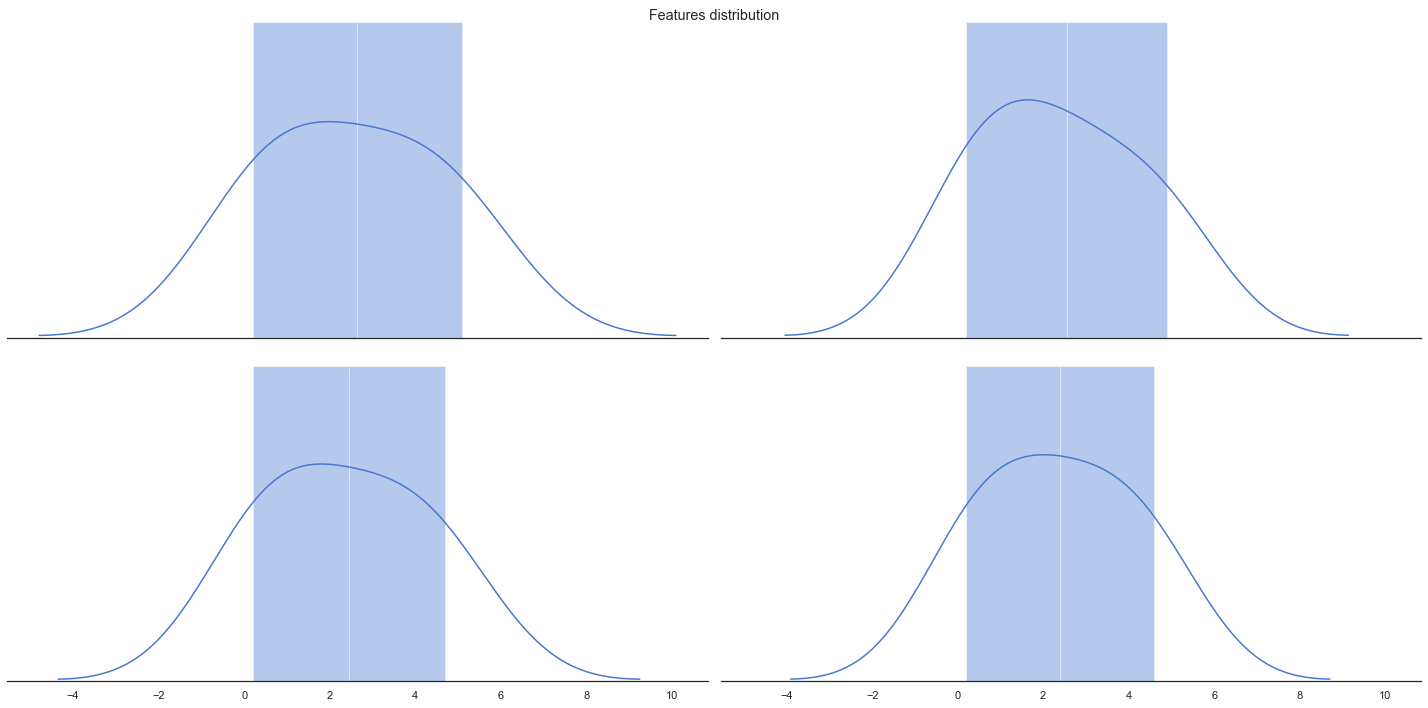

In [22]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
sns.despine(left=True)
f.suptitle('Features distribution')
# Plot a histogram and kernel density estimate
sns.distplot(data[0], color="b", ax=axes[0, 0])
sns.distplot(data[1], color="b", ax=axes[0, 1])
sns.distplot(data[2], color="b", ax=axes[1, 0])
sns.distplot(data[3], color="b", ax=axes[1, 1]) 

plt.setp(axes, yticks=[])
plt.tight_layout()

**train IRIS**

Imaplanced training data:

(array([39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 66.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

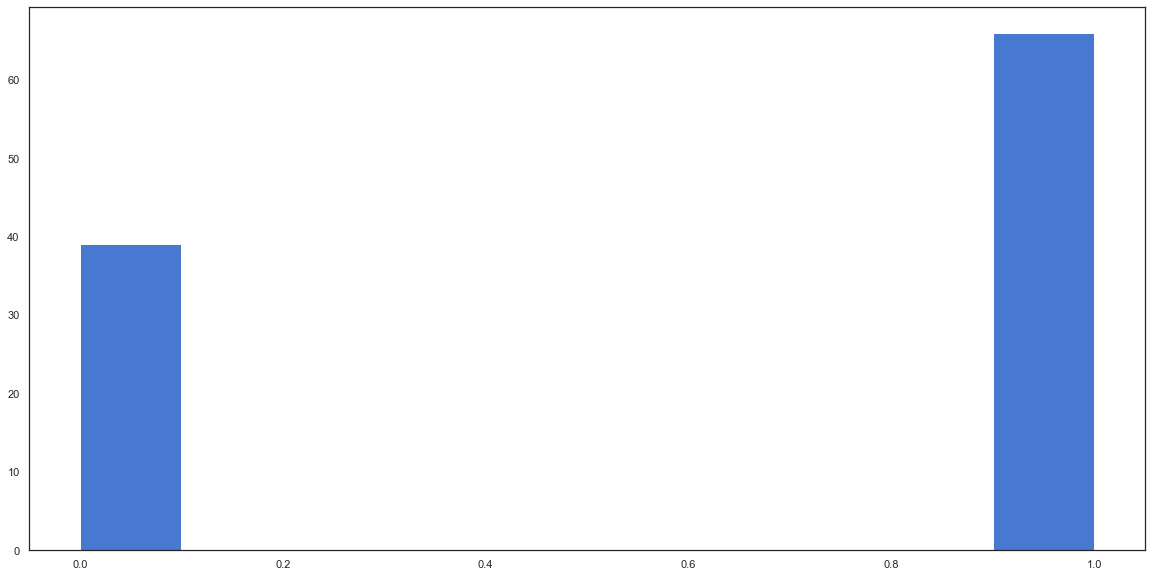

In [23]:
plt.figure(figsize=(20,10))
plt.hist(target_train)

In [24]:
data_train_std = StandardScaler().fit_transform(data_train)
data_test_std = StandardScaler().fit_transform(data_test)
clf= SVC()
clf.fit(data_train_std, target_train)
target_pred= clf.predict(data_test_std)
confusionMatrix = confusion_matrix(target_test, target_pred)
accuracyScore = accuracy_score(target_test, target_pred)
classificationReport = classification_report(target_test, target_pred)
print(classificationReport)

print('Test accuracy before oversampling:',accuracy_score(target_pred, target_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        34

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Test accuracy before oversampling: 1.0


**Implement and train SMOTE on IRIS**

Now we double the class 0 

In [25]:
def nearest_neighbour(X, x):
    euclidean = np.ones(X.shape[0]-1)
    
    additive = [None]*(1*X.shape[1])
    additive = np.array(additive).reshape(1, X.shape[1])
    k = 0
    for j in range(0,X.shape[0]):
        if np.array_equal(X[j], x) == False:
            euclidean[k] = np.sqrt(sum((X[j]-x)**2))
            k = k + 1
    euclidean = np.sort(euclidean)
    weight = random.random()
    while(weight == 0):
        weight = random.random()
    additive = np.multiply(euclidean[:1],weight)
    return additive
    
def SMOTE_100(X):
    new = [None]*(X.shape[0]*X.shape[1])
    new = np.array(new).reshape(X.shape[0],X.shape[1])
    k = 0
    for i in range(0,X.shape[0]):
        additive = nearest_neighbour(X, X[i])
        for j in range(0,1):
            new[k] = X[i] + additive[j]
            k = k + 1
    return new 

(array([78.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 66.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

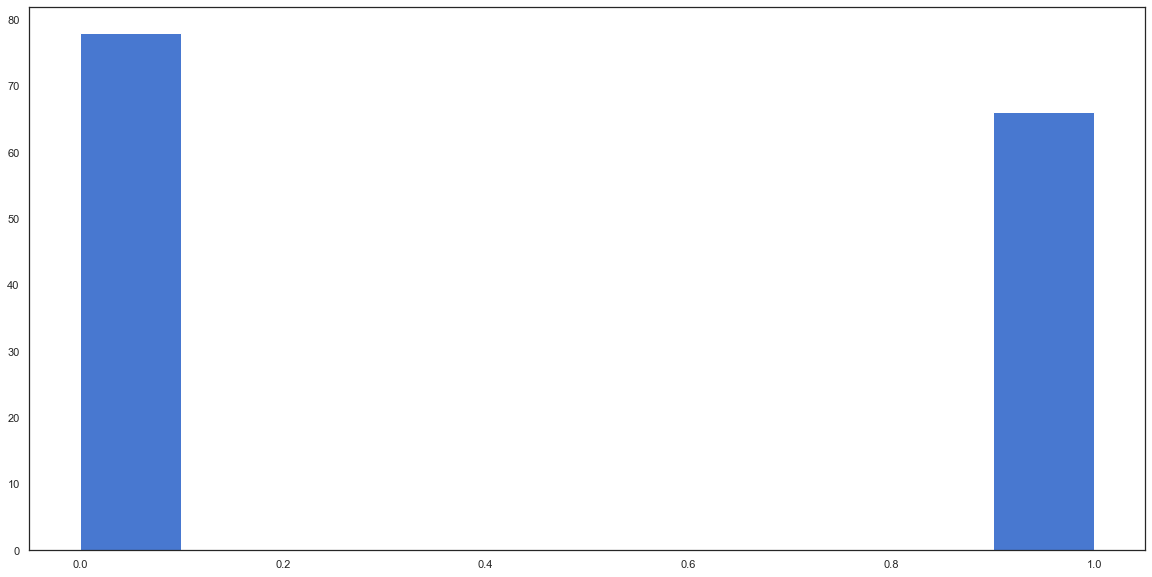

In [26]:
# 1. Getting the number of Minority Class Instances in Training Set
unique, counts = np.unique(target_train, return_counts=True)
minority_shape = dict(zip(unique, counts))[0]
# 2. Storing the minority class instances separately
x1 = np.ones((minority_shape, data_train.shape[1]))
k=0
for i in range(0,data_train.shape[0]):
    if target_train[i] == 0.0:
        x1[k] = data_train[i]
        k = k + 1
# 3. Applying 100% SMOTe
sampled_instances = SMOTE_100(x1)
# Keeping the artificial instances and original instances together
data_train_new = np.concatenate((data_train,sampled_instances), axis = 0)
y_sampled_instances = np.zeros(minority_shape)
target_train_new = np.concatenate((target_train,y_sampled_instances), axis=0)
# X_f and y_f are the Training Set Features and Labels respectively 
plt.figure(figsize=(20,10))
plt.hist(target_train_new)

Now lets see our accurecy after balancing the data:

In [27]:
data_train_std = StandardScaler().fit_transform(data_train_new)
clf= SVC()
clf.fit(data_train_std, target_train_new)
targety_pred= clf.predict(data_test_std)
confusionMatrix = confusion_matrix(target_test, target_pred)
accuracyScore = accuracy_score(target_test, target_pred)
classificationReport = classification_report(target_test, target_pred)
print(classificationReport)

print('Test accuracy after oversampling:',accuracy_score(target_pred, target_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        34

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Test accuracy after oversampling: 1.0


In this case with Iris dataset both balanced and Imbalanced data had 100% accurecy and therefore no improvment was observed. However in other datasets it may result in improvements.

 <br/>
 <br/>

 ## Clustering

 ---
 ---

 ### Problem 5: Describe the main differences between K-means and DB-Scan, use examples.  (10)



 > __NOTE__: (scikit)

 ---


In [28]:
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN, KMeans
from mpl_toolkits.mplot3d import Axes3D

**Differences between DBScan and KMeans:**

The main difference is that they work completely differently and solve different problems. Kmeans is a least-squares optimization, whereas DBSCAN finds density-connected regions. Which technique is appropriate to use depends on your data and objectives. If you want to minimize least squares, use k-means. If you want to find density-connected regions use DBSCAN.

**Advantages and disadvantages of KMeans:**

- KMeans is much faster than DBScan
- Kmeans tries to create same sized cluster no matter how the data is scattered
- Kmeans doesnt work well for non-globular structures
- Kmeans doesnt care about how dense the data is present
Curse of dimensionality affects kmeans at high dimension since it uses distance measure

**Advantages and disadvantages of DBScan:**

- DBScan doesn’t need number of clusters
- DBScan doesn’t work well over clusters with different densities
- DBScan needs a careful selection of its parameters

**An example of KMeans failing and DBScan succes: (Circles data)**

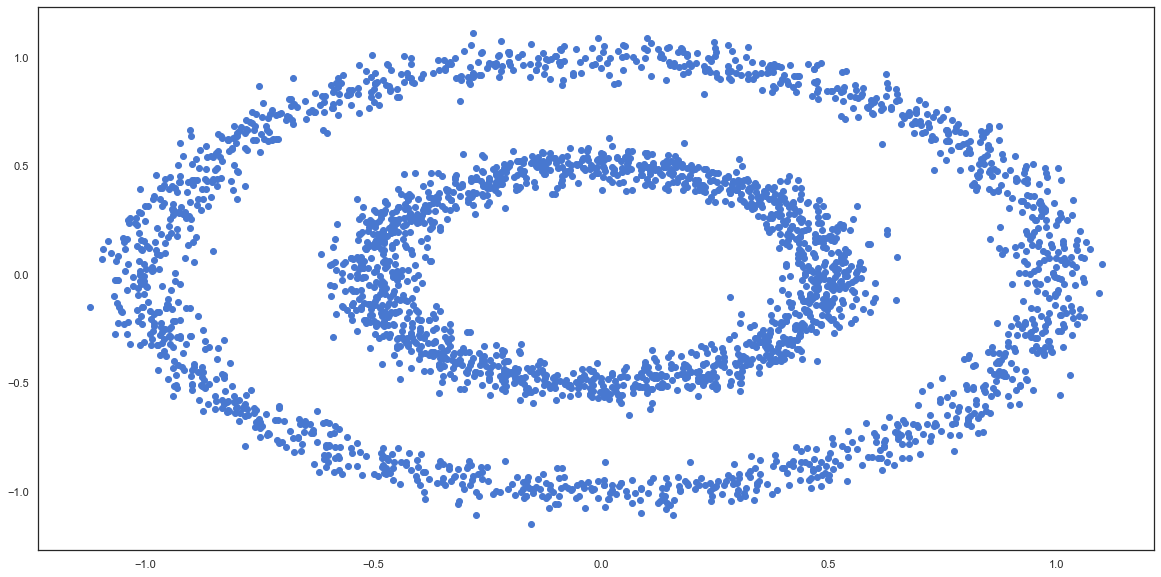

In [29]:
plt.rcParams['figure.figsize'] = (20, 10)

# Creating a sample dataset with 4 clusters
n_samples = 3000
X,y = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1])

**DBScan**

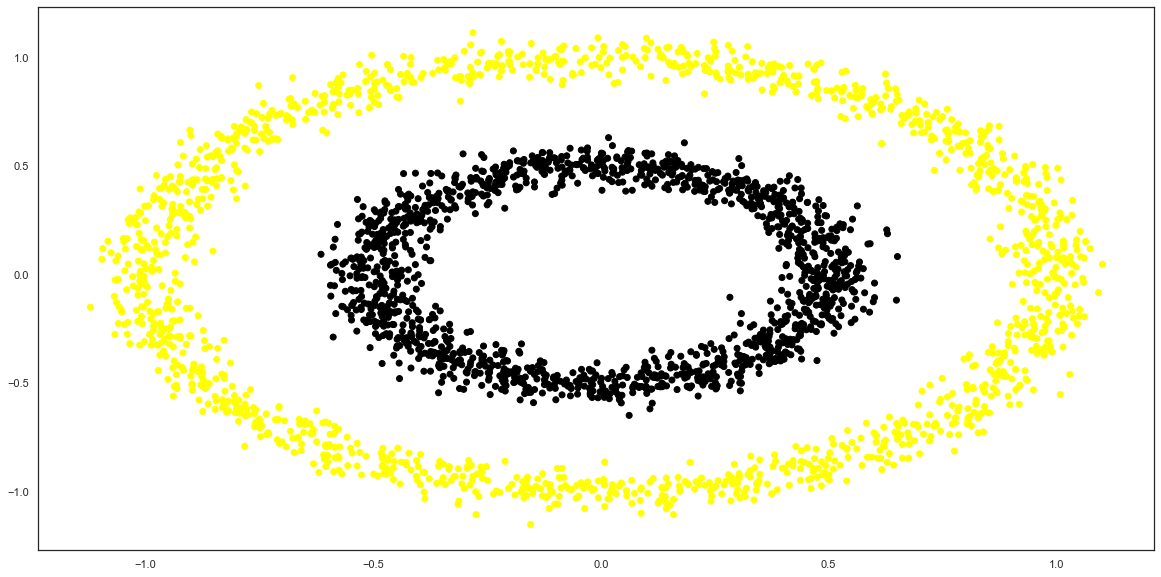

In [30]:
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=1, cmap='gnuplot')

Now lets look at some indices:

In [31]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.113


**KMeans**

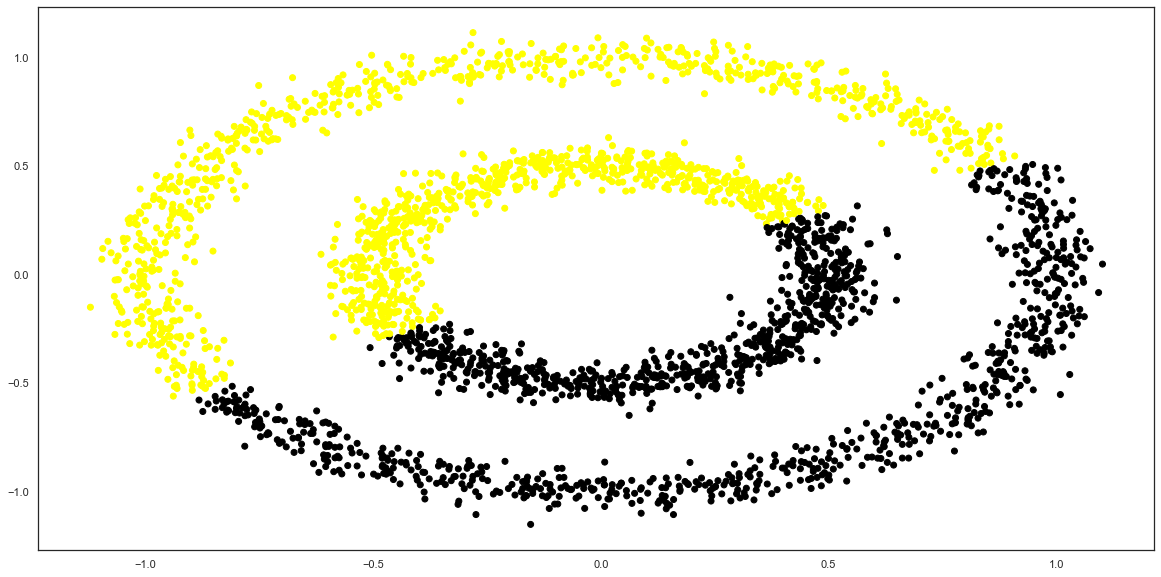

In [32]:
kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels,alpha=1,cmap='gnuplot')

In [33]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.355


As expected Kmeans is unable to correctly classify this type of dataset.

**An example of DBScan failing and KMeans succes: (Blobs data)**

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


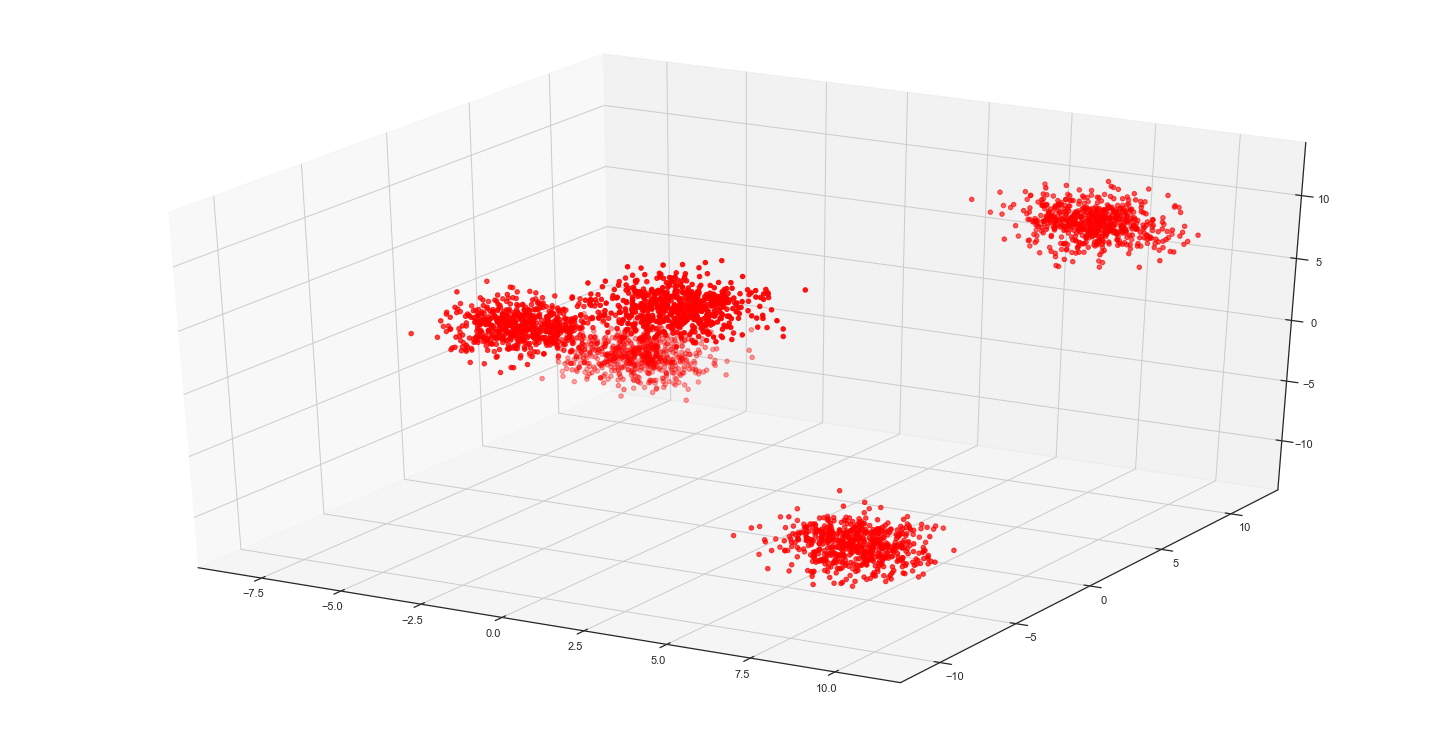

In [34]:
plt.rcParams['figure.figsize'] = (20, 10)
# Creating a sample dataset with 4 clusters
X, y = datasets.make_blobs(n_samples=3000, n_features=4, centers=5, random_state=1000)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], X[:, 3], color=['red'])

**DBScan**

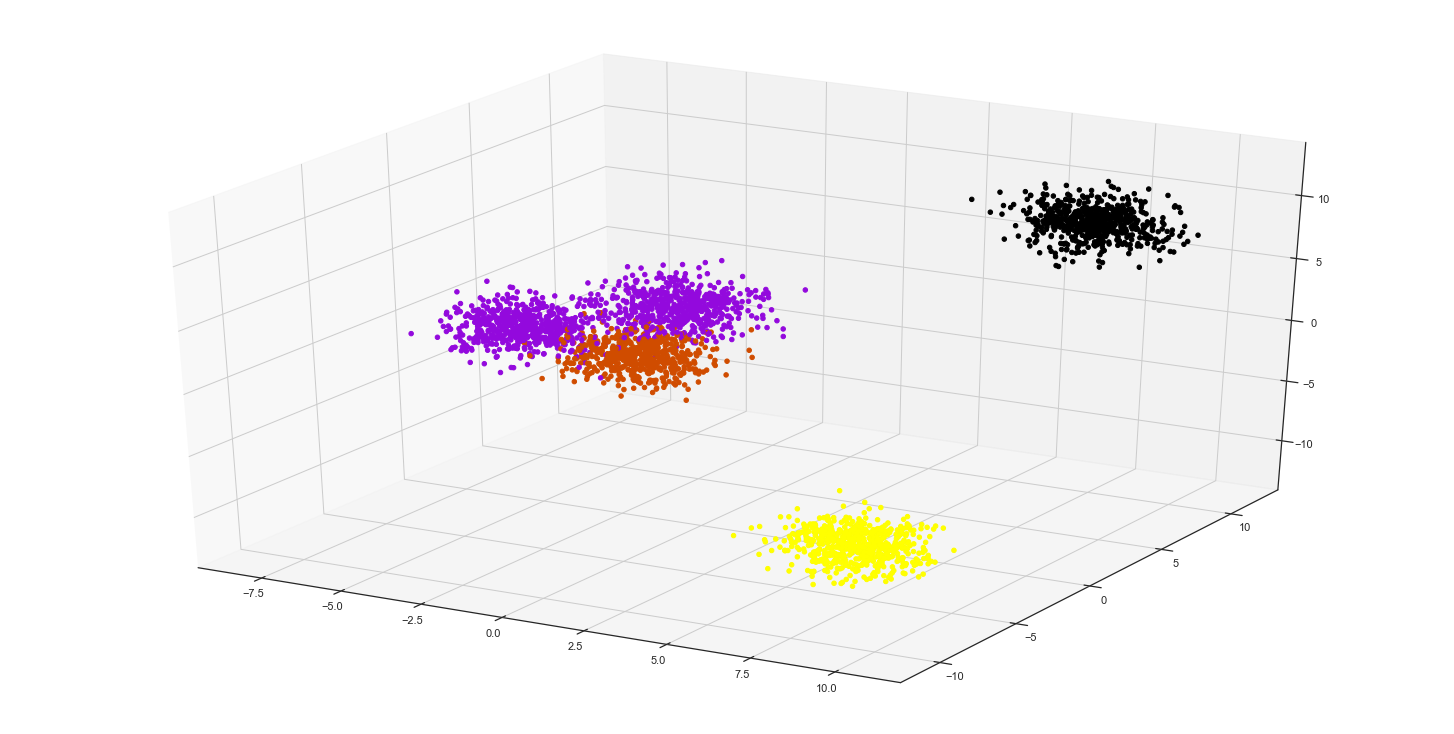

In [35]:
db = DBSCAN(eps=8, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels,alpha=1,cmap='gnuplot')

In [36]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 0.828
Completeness: 1.000
V-measure: 0.906
Adjusted Rand Index: 0.782
Adjusted Mutual Information: 0.906
Silhouette Coefficient: 0.762


**KMeans**

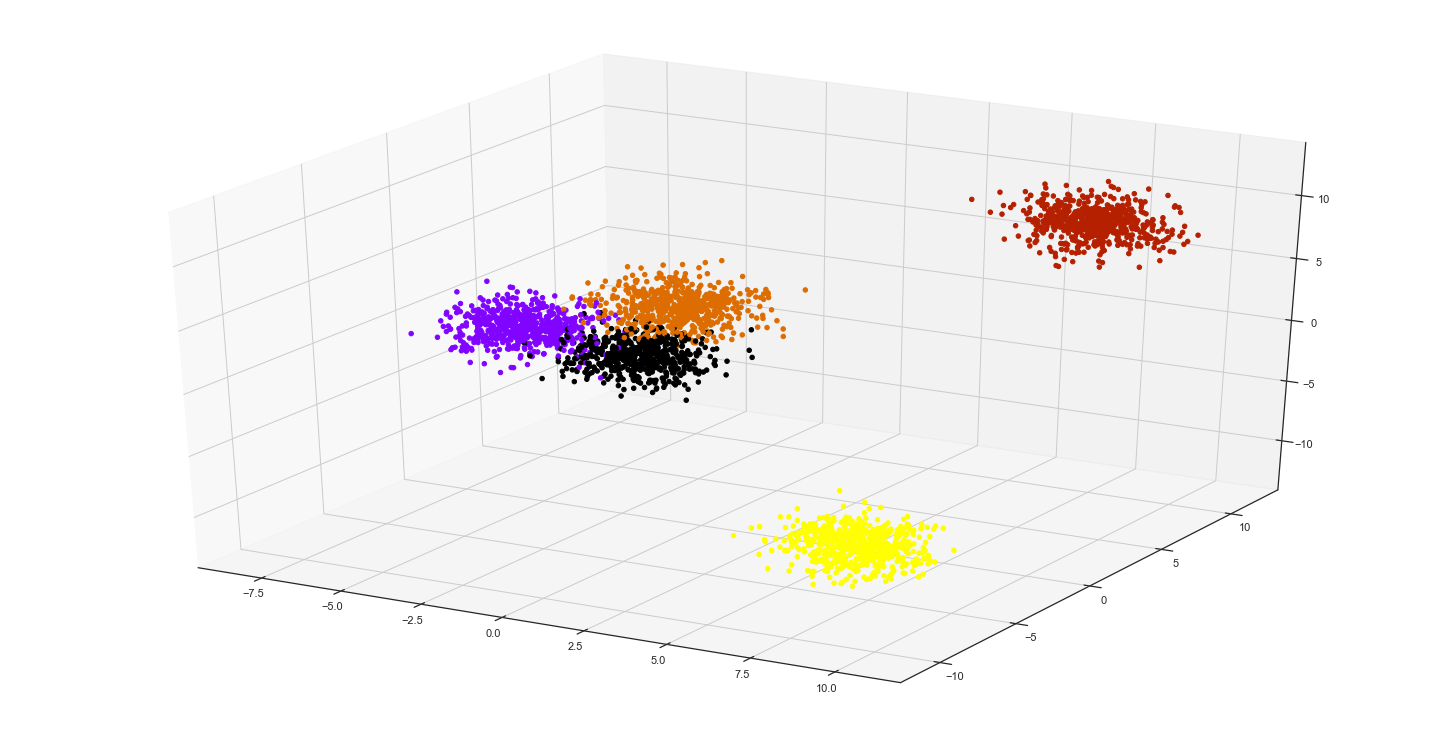

In [37]:
kmeans = KMeans(n_clusters=5)
kmeans = kmeans.fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels,alpha=1,cmap='gnuplot')

In [38]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_true=y
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 5
Estimated number of noise points: 0
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.814


As expected DBScan is unable to correctly classify this type of dataset.

 ### Problem 6: Implement a procedure to estimate the optimal number of clusters in the k-Means and Gaussian mixture model  (20)



 > __NOTE__: (try to differentiate the two procedures).
 >  (scikit)


In [39]:
from sklearn.metrics import silhouette_samples

Generate the Data:

<Figure size 1440x720 with 0 Axes>

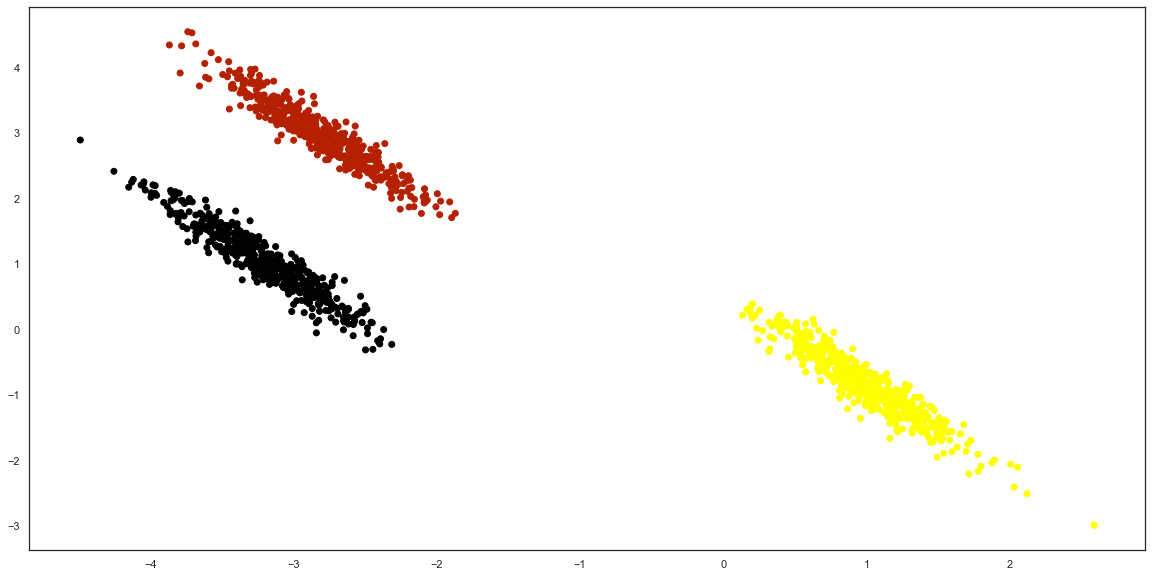

In [40]:
random_state = 170
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state,cluster_std=0.5)
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
X_std=StandardScaler().fit_transform(X_aniso)
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y,alpha=1,cmap='gnuplot')

**Evaluation Methods**

Contrary to supervised learning where we have the ground truth to evaluate the model’s performance, clustering analysis doesn’t have a solid evaluation metric that we can use to evaluate the outcome of different clustering algorithms. Moreover, since kmeans requires k as an input and doesn’t learn it from data, there is no right answer in terms of the number of clusters that we should have in any problem. Sometimes domain knowledge and intuition may help but usually that is not the case. In the cluster-predict methodology, we can evaluate how well the models are performing based on different K clusters since clusters are used in the downstream modeling.
In this post we’ll cover two metrics that may give us some intuition about k:
- Elbow method
- Silhouette analysis
- Akaike information criterion (AIC) 
- Bayesian information criterion (BIC)

> **Elbow Method and BIC**

We use Elbow method on KMeans and BIC on GaussianMixture:

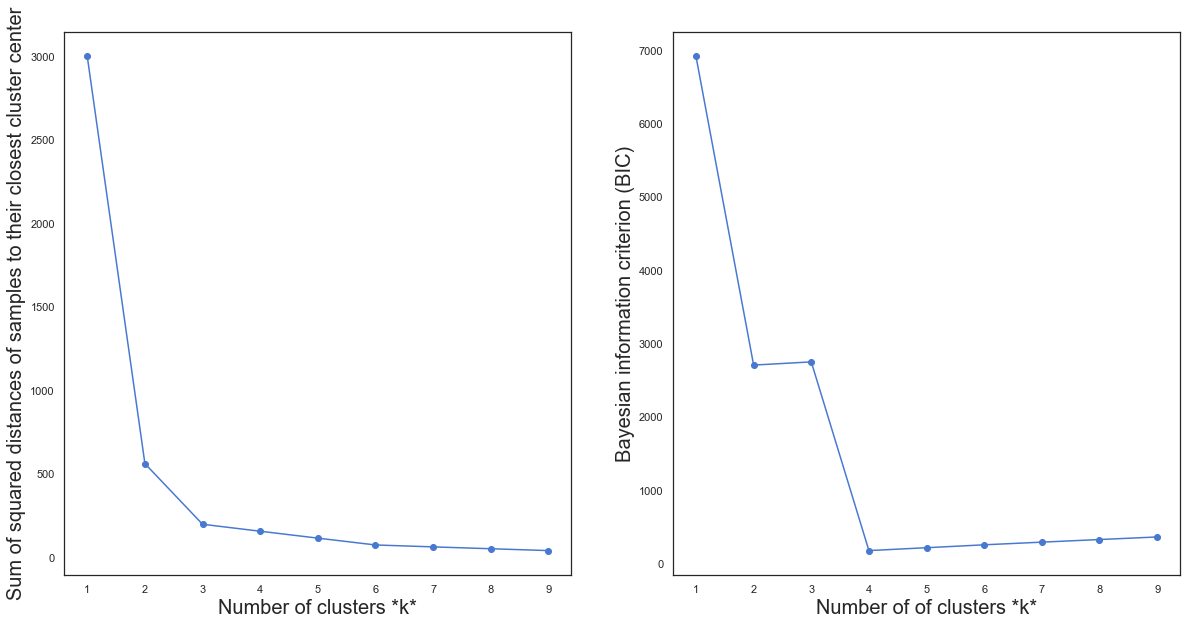

In [41]:
sse_kmean = []
sse_gmm = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k).fit(X_std)
    sse_kmean.append(km.inertia_)
    gmm = GaussianMixture(n_components=k).fit(X_std)
    sse_gmm.append(gmm.bic(X_std))
    
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

plt.plot(list_k, sse_kmean, '-o')
plt.xlabel(r'Number of clusters *k*',fontsize=20)
plt.ylabel('Sum of squared distances of samples to their closest cluster center',fontsize=20)

plt.subplot(1, 2, 2)
plt.plot(list_k, sse_gmm, '-o')
plt.xlabel(r'Number of of clusters *k*',fontsize=20)
plt.ylabel('Bayesian information criterion (BIC)',fontsize=20)
plt.show()

Both methods suggest that both KMeans and GaussianMixture find 3 clusters as optimum amount.

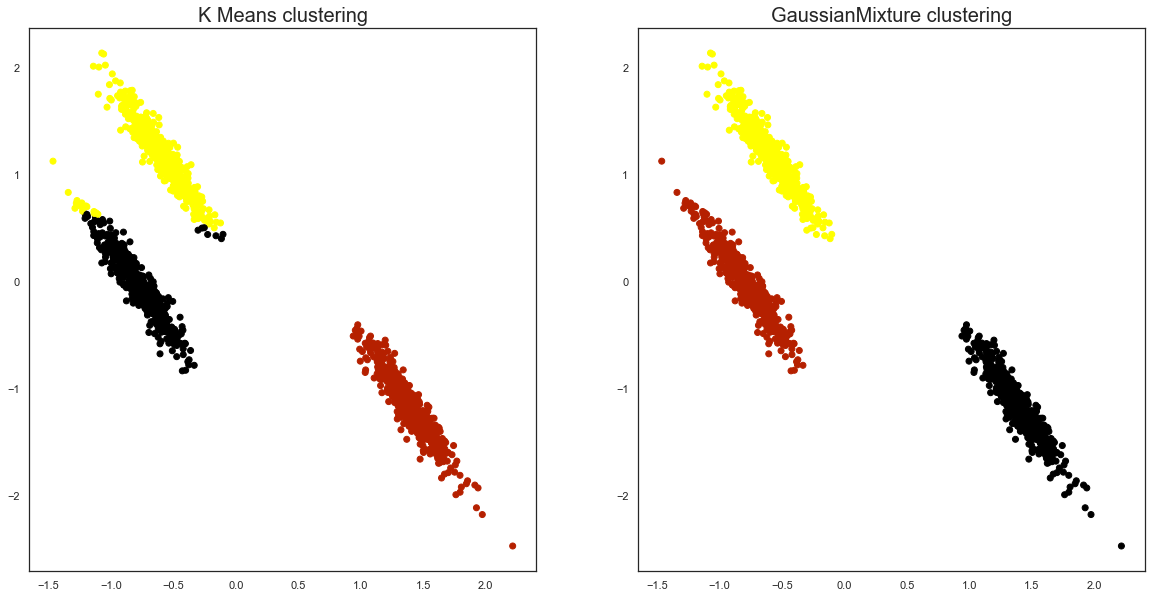

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

km = KMeans(n_clusters=3).fit(X_std)
labels_kmean = km.labels_
plt.scatter(X_std[:, 0], X_std[:, 1], c=labels_kmean,alpha=1,cmap='gnuplot')
plt.title('K Means clustering',fontsize=20)

plt.subplot(1, 2, 2)
gmm = GaussianMixture(n_components=3).fit(X_std)
labels_gmm = gmm.predict(X_std)
plt.scatter(X_std[:, 0], X_std[:, 1], c=labels_gmm,alpha=1,cmap='gnuplot')
plt.title('GaussianMixture clustering',fontsize=20)
plt.show()

> **Silhouette analysis and AIC**

We use Silhouette analysis on KMeans and AIC on GaussianMixture:

Now lets look more closly at 2, 3, and 4 clusters.

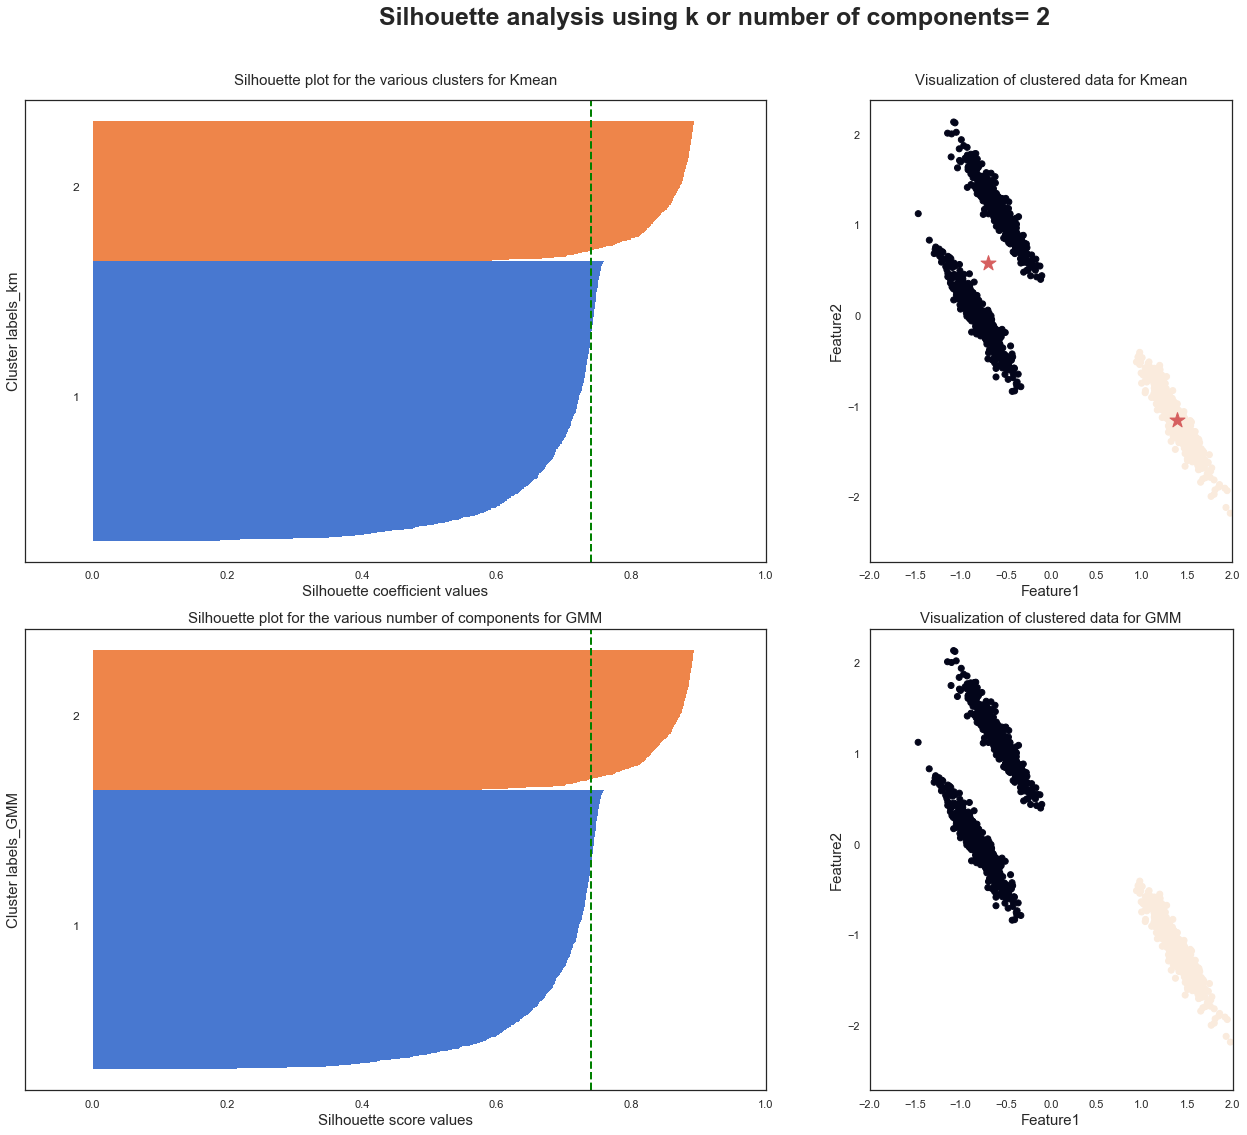

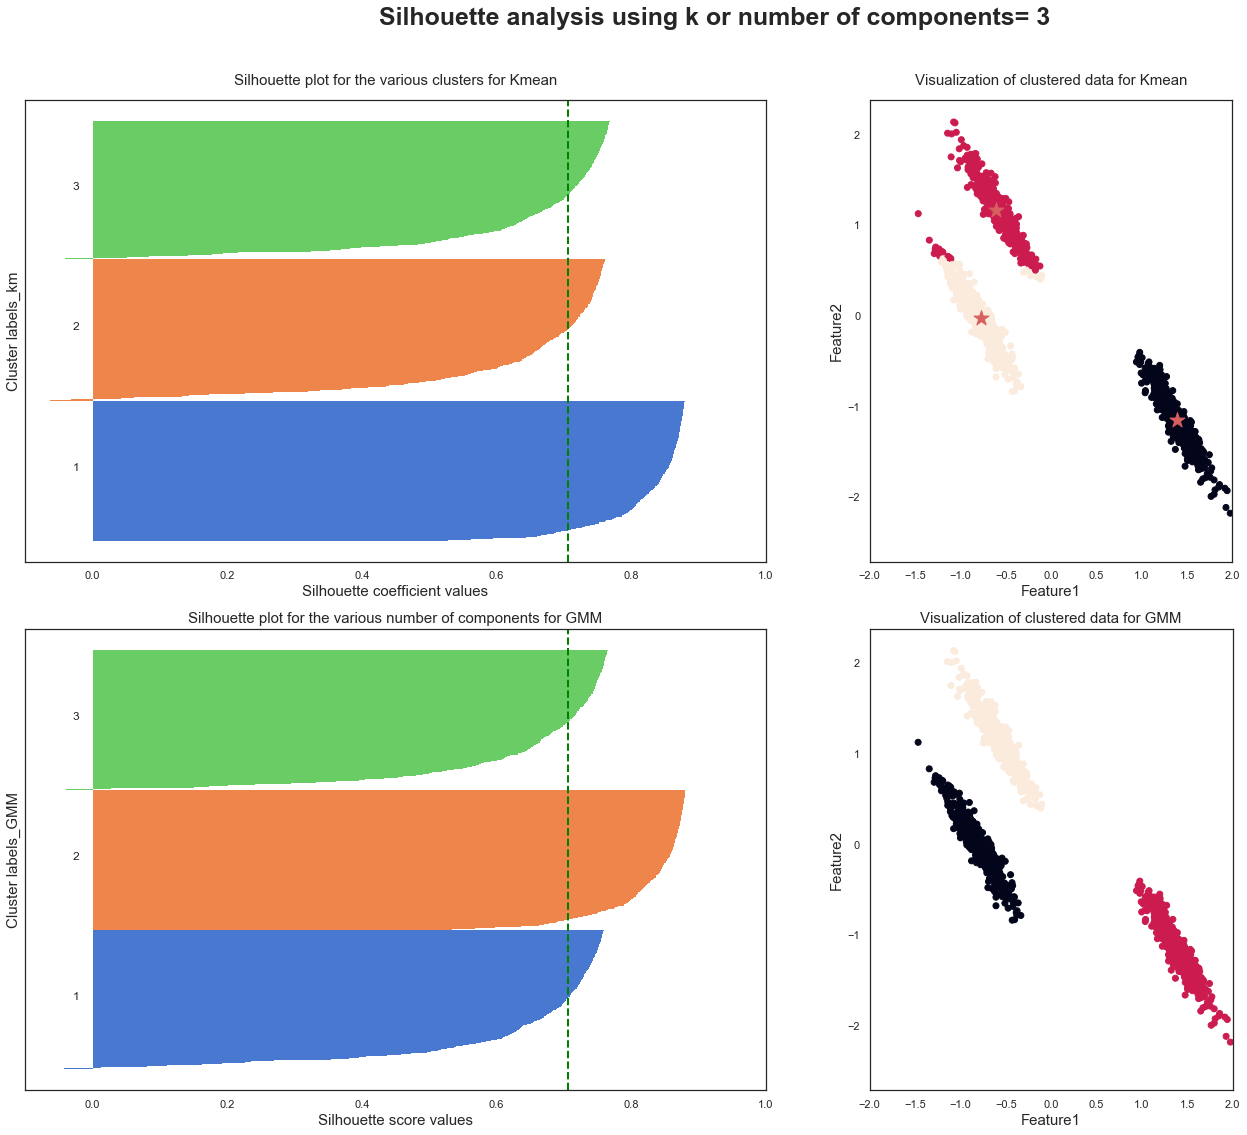

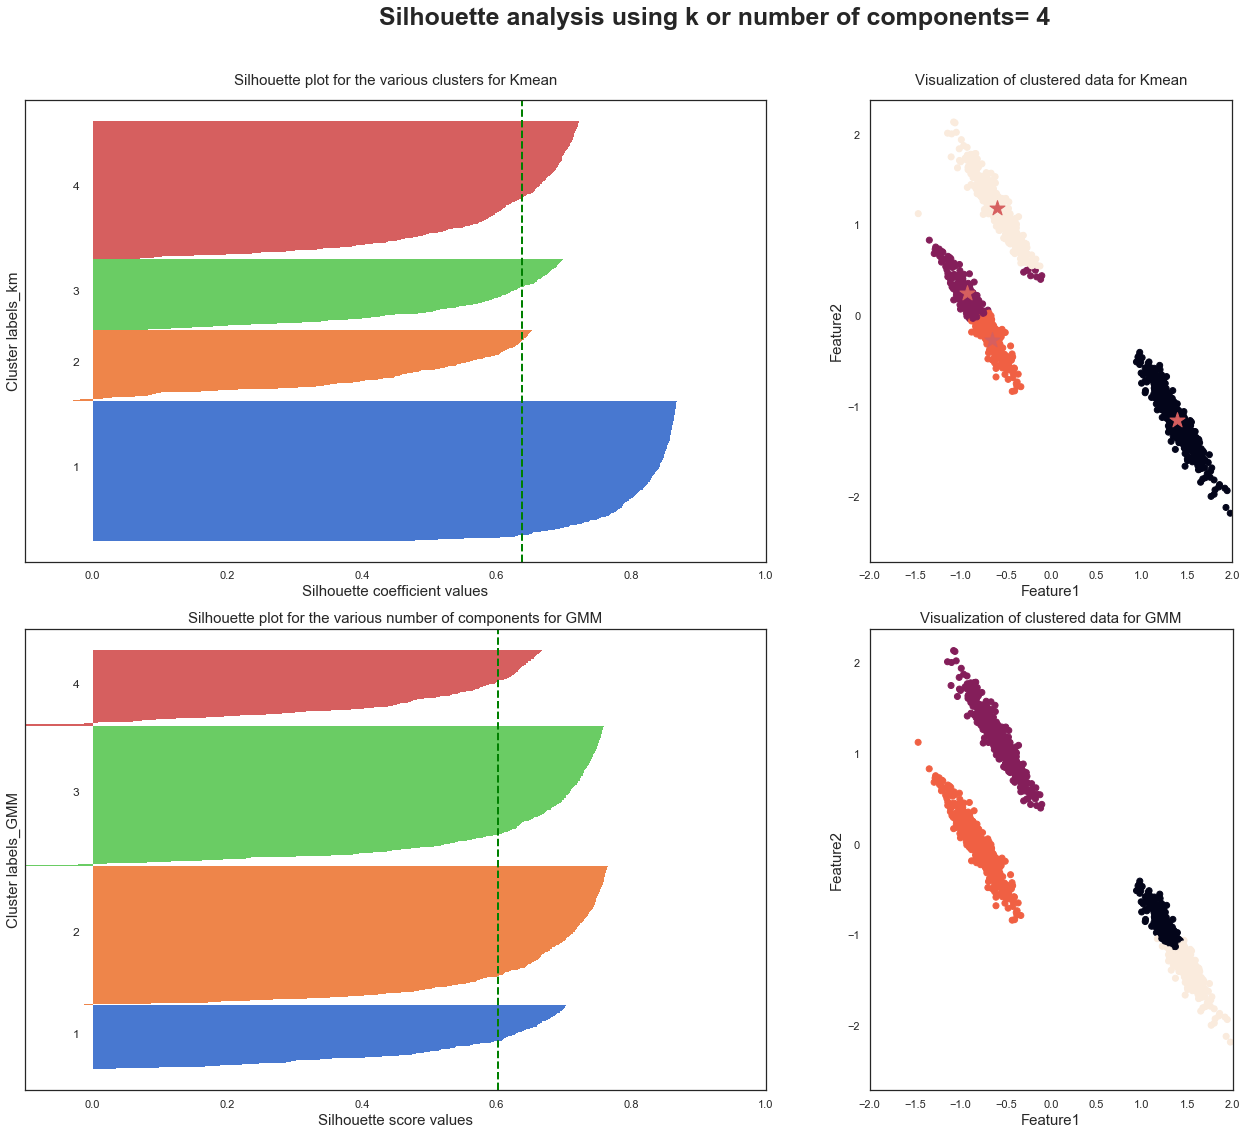

In [43]:
for i, k in enumerate([2, 3, 4]):
    fig, axis = plt.subplots(2, 2,figsize=[20,15])
    axis = axis.flatten()
    ax1, ax2,ax3,ax4=axis
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels_km = km.fit_predict(X_std)
    centroids = km.cluster_centers_
    
    gmm = GaussianMixture(n_components=k)
    labels_gmm = gmm.fit_predict(X_std)
    

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels_km)
    
    # AIC 
    AIC_vals = silhouette_samples(X_std, labels_gmm)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels_km)):
        cluster_silhouette_vals = silhouette_vals[labels_km == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)
        
    # AIC plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels_gmm)):
        cluster_AIC_vals = AIC_vals[labels_gmm == cluster]
        cluster_AIC_vals.sort()
        y_upper += len(cluster_AIC_vals)
        ax3.barh(range(y_lower, y_upper), cluster_AIC_vals, edgecolor='none', height=1)
        ax3.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_AIC_vals)

    # Get the average silhouette score and plot it
    
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values',fontsize=15)
    ax1.set_ylabel('Cluster labels_km',fontsize=15)
    ax1.set_title('Silhouette plot for the various clusters for Kmean', y=1.02,fontsize=15);
    
    
    
    # Scatter plot of data colored with labels_km
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels_km)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Feature1',fontsize=15)
    ax2.set_ylabel('Feature2',fontsize=15)
    ax2.set_title('Visualization of clustered data for Kmean', y=1.02,fontsize=15)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);
    # Get the average AIC score and plot it
    avg_score = np.mean(AIC_vals)
    ax3.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax3.set_yticks([])
    ax3.set_xlim([-0.1, 1])
    ax3.set_xlabel('Silhouette score values',fontsize=15)
    ax3.set_ylabel('Cluster labels_GMM',fontsize=15)
    ax3.set_title('Silhouette plot for the various number of components for GMM', y=1.02,fontsize=15);
    
    # Scatter plot of data colored with labels_gmm
    ax4.scatter(X_std[:, 0], X_std[:, 1], c=labels_gmm)
    ax4.set_xlim([-2, 2])
    ax4.set_xlim([-2, 2])
    ax4.set_xlabel('Feature1',fontsize=15)
    ax4.set_ylabel('Feature2',fontsize=15)
    ax4.set_title('Visualization of clustered data for GMM', y=1.02,fontsize=15)
    ax4.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k or number of components= {k}',
                 fontsize=25, fontweight='semibold', y=1.05);

As the above silhouette score plots show, n_clusters=2 has the best average silhouette score of around 0.75 and all clusters being above the average shows that it is actually a good choice. Also, the thickness of the silhouette plot gives an indication of how big each cluster is.

Now lets try AIC:

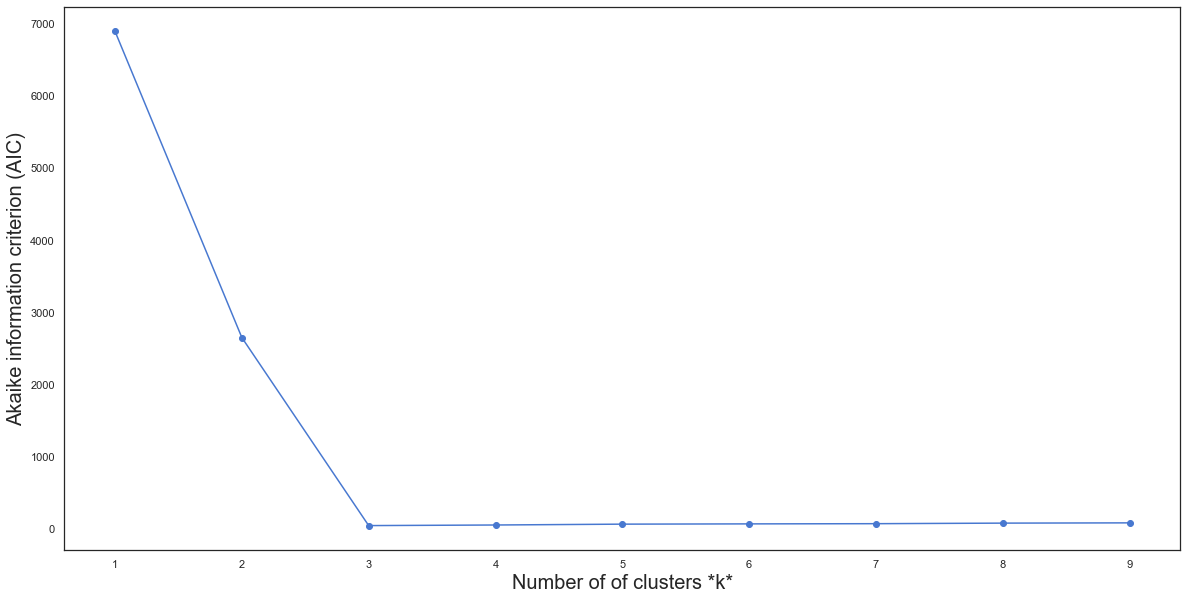

In [44]:
sse_gmm = []
list_k = list(range(1, 10))

for k in list_k:
    gmm = GaussianMixture(n_components=k).fit(X_std)
    sse_gmm.append(gmm.aic(X_std))
    
plt.figure(figsize=(20,10))

plt.plot(list_k, sse_gmm, '-o')
plt.xlabel(r'Number of of clusters *k*',fontsize=20)
plt.ylabel('Akaike information criterion (AIC)',fontsize=20)
plt.show()

AIC suggest that 3 is optimum number of cluster for GMM.

 ### Problem 7: Implement the algorithm of hierarchical clustering with maximum or complete linkage  (20)



 > __NOTE__: this can help www.econ.upf.edu/~michael/stanford/maeb7.pdf

 ---


In [45]:
import math
from scipy.spatial import distance

>**Single-Linkage** <br>

Single-linkage (nearest neighbor) is the shortest distance between a pair of observations in two clusters. It can sometimes produce clusters where observations in different clusters are closer together than to observations within their own clusters. These clusters can appear spread-out. <br>
<br>
>**Complete-Linkage** <br>

Complete-linkage (farthest neighbor) is where distance is measured between the farthest pair of observations in two clusters. This method usually produces tighter clusters than single-linkage, but these tight clusters can end up very close together. Along with average-linkage, it is one of the more popular distance metrics.<br>

Use the generated data in problem 1

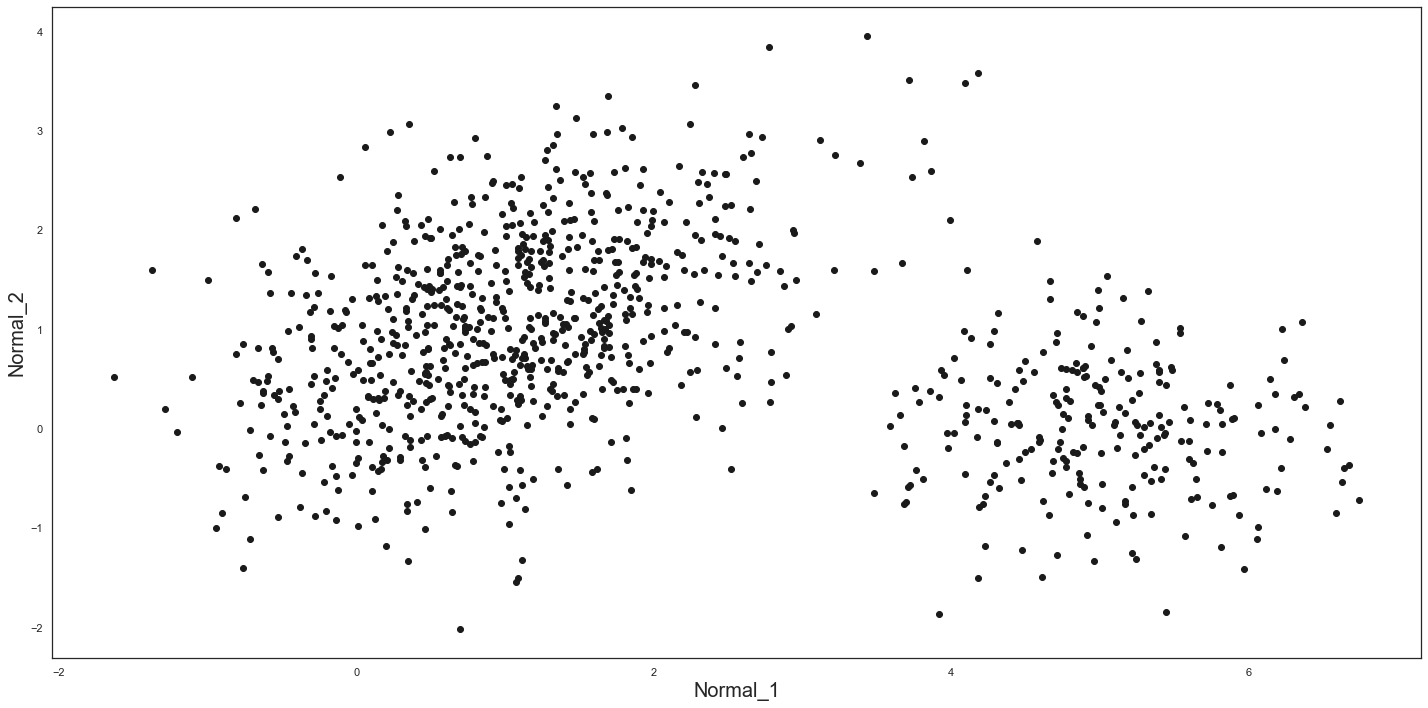

In [46]:
fig = plt.figure(figsize = (20,10))
X=data
plt.plot(N_Data[:, 0], N_Data[:, 1], 'ko')
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
plt.tight_layout()

In [47]:
data_train, data_test = train_test_split(np.array(N_Data),  test_size=0.3, random_state=1000)
Data = pd.DataFrame(data_test,columns=['x0', 'x1'])

**Build a Hierachical model**

In [48]:
def hierarchical(data, cluster_num, metric):
    # initialization of clusters at first (every point is a cluster)
    init_clusters=[]
    for index, row in data.iterrows():
        init_clusters.append([[row['x0'], row['x1']]])
    if metric is 'single':
        return single_distance(init_clusters, cluster_num)
    else:
        #metric is 'complete':
        return complete_distance(init_clusters, cluster_num)

**Build Single linkage**

In [49]:
def single_distance(clusters ,cluster_num):
    #print('first cluster | ','second cluster | ', 'distance')
    while len(clusters) is not cluster_num:
        # Clustering           (
        closest_distance=clust_1=clust_2 = math.inf
        # for every cluster (until second last element)
        for cluster_id, cluster in enumerate(clusters[:len(clusters)]): 
            # for each point in each cluster
            for point_id,point in enumerate(cluster): 
                # we only need to compare with clusters after the current one
                for cluster2_id, cluster2 in enumerate(clusters[(cluster_id+1):]): 
                    # go through every point in this prospective cluster as well
                    for point2_id, point2 in enumerate(cluster2):
                        # if this distance is better than our previous best distance then we are going to overwrite it
                        if distance.euclidean(point,point2) < closest_distance: 
                            # Only used for comparing 
                            closest_distance = distance.euclidean(point,point2)
                            # this will be used at the end to figure out which cluster to merge with which
                            clust_1 = cluster_id
                            # this cluster will be destroyed by the end
                            clust_2 = cluster2_id+cluster_id+1
                            # extend just appends the contents to the list without flattening it out
        #print(clust_1,' | ',clust_2, ' | ',closest_distance)
        clusters[clust_1].extend(clusters[clust_2]) 
        # don't need this index anymore, and we have just clustered once more
        clusters.pop(clust_2) 
    return(clusters)

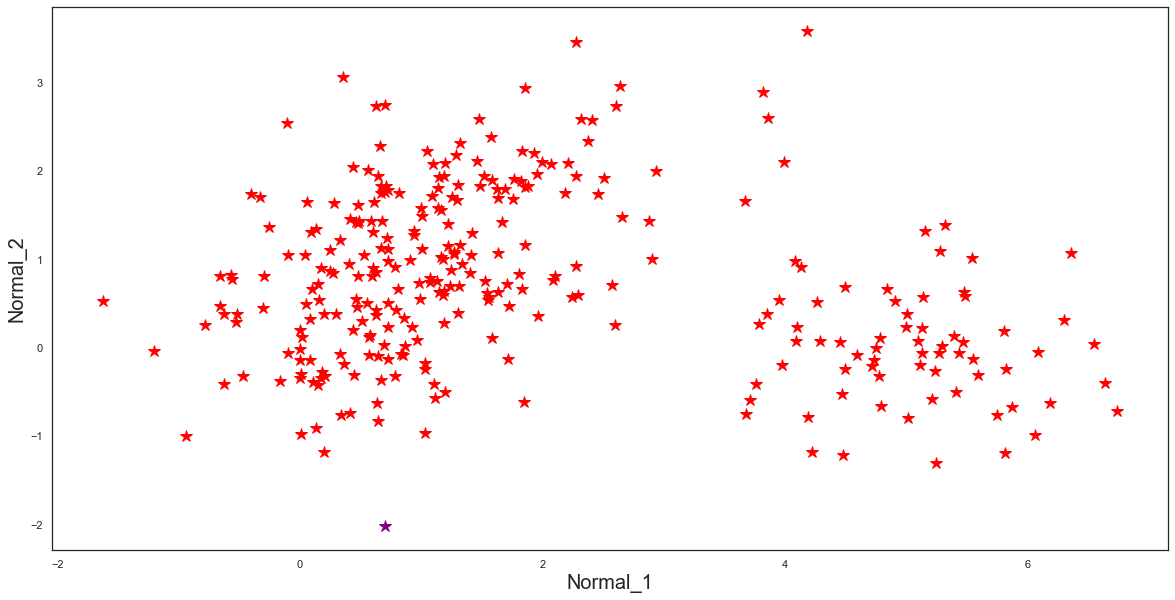

In [50]:
clusters = hierarchical(Data, 2, 'single')
colors = ['red', 'purple']
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
for cluster_index, cluster in enumerate(clusters):
    for point_index, point in enumerate(cluster):
        plt.plot([point[0]], [point[1]], marker='*', markersize=12, color=colors[cluster_index])
        

**Build Complete linkage**

In [51]:
def complete_distance(clusters ,cluster_num):
    #print('first cluster | ','second cluster | ', 'distance')
    while len(clusters) is not cluster_num:
        # Clustering           (
        closest_distance=clust_1=clust_2 = math.inf
        # for every cluster (until second last element)
        for cluster_id, cluster in enumerate(clusters[:len(clusters)]): 
            for cluster2_id, cluster2 in enumerate(clusters[(cluster_id+1):]):  
                furthest_cluster_dist = -1
                # this is different from the complete link in that we try to minimize the MAX distance
                # between CLUSTERS
                # go through every point in this prospective cluster as well
                # for each point in each cluster
                for point_id,point in enumerate(cluster): 
                    for point2_id, point2 in enumerate(cluster2):
                        # make sure that our furthest distance holds the maximum distance betweeen the clusters at focus
                        if furthest_cluster_dist < distance.euclidean(point,point2): 
                            furthest_cluster_dist = distance.euclidean(point,point2)
                            # We are now trying to minimize THAT furthest dist
                if furthest_cluster_dist < closest_distance:
                    closest_distance = furthest_cluster_dist
                    clust_1 = cluster_id
                    clust_2 = cluster2_id+cluster_id+1
                   # extend just appends the contents to the list without flattening it out
        #print(clust_1,' | ',clust_2, ' | ',closest_distance)
        clusters[clust_1].extend(clusters[clust_2]) 
        # don't need this index anymore, and we have just clustered once more
        clusters.pop(clust_2) 
    return(clusters)

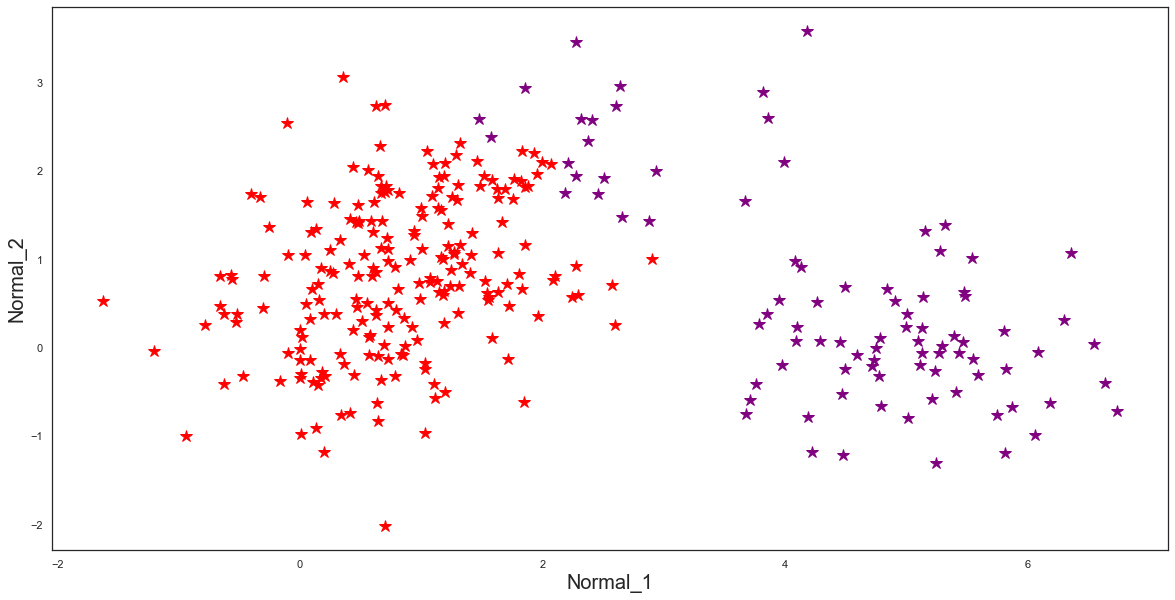

In [52]:
clusters = hierarchical(Data, 2, 'complete')
colors = ['red', 'purple']
plt.xlabel('Normal_1',fontsize=20)
plt.ylabel('Normal_2',fontsize=20)
for cluster_index, cluster in enumerate(clusters):
    for point_index, point in enumerate(cluster):
        plt.plot([point[0]], [point[1]], marker='*', markersize=12, color=colors[cluster_index])

As demonstrated above Single distance is unable to correctly identify two clusters as observations in different clusters are closer together than to observations within their own cluster in this case, whereas the complete linkage works much better in seperateing the two normall distributions.